In [18]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import cross_validate
import matplotlib.pyplot as plt
%matplotlib inline

## Leitura do dataset

In [52]:
dataset = pd.read_csv('coverage-dataset4.csv', sep=';')
dataset.head(5)

Name  CountInput  CountLine  \
0  com.puppycrawl.tools.checkstyle.Checker.clearC...           4          8   
1  com.puppycrawl.tools.checkstyle.DefaultConfigu...        1169         14   
2  com.puppycrawl.tools.checkstyle.Checker.destroy()          20         14   
3  com.puppycrawl.tools.checkstyle.Checker.setCac...           6         10   
4  com.puppycrawl.tools.checkstyle.Checker.fireFi...           6         13   

   CountLineBlank  CountLineCode  CountLineCodeDecl  CountLineCodeExe  \
0               0              5                  1                 2   
1               0              9                  2                 5   
2               0             14                  1                 9   
3               0              5                  2                 3   
4               0              7                  3                 4   

   CountLineComment  CountOutput  CountPath  ...  CyclomaticStrict.1  \
0                 3            1          2  ...                   1   
1                 5            2          2  ...                   1   
2                 0            4          3  ...                   1   
3                 5            4          1  ...                   1   
4                 6            3          2  ...                   1   

   Essential.1  Knots.1  MaxEssentialKnots.1  MaxNesting.1  \
0            1        0                    0             1   
1            1        0                    0             1   
2            1        0                    0             1   
3            1        0                    0             1   
4            1        0                    0             0   

   MinEssentialKnots.1  RatioCommentToCode.1  EdgeCoverage  PrimePathCoverage  \
0                    0                  0.05        0,0000                NaN   
1                    0                  0.05        1,0000                NaN   
2                    0                  0.08        0,7500             0,0000   
3                    0                  0.08        1,0000             1,0000   
4                    0                  0.03        1,0000             1,0000   

   Unnamed: 50  
0          NaN  
1          NaN  
2          NaN  
3          NaN  
4          NaN  

[5 rows x 51 columns]

## Pré-processamento

In [53]:
# Remove ultima coluna vazia
dataset = dataset.iloc[:,:-1]

# Remove NaN
dataset = dataset.dropna()

# Converte valores de cobertura em float
dataset.iloc[:,-1] = dataset.iloc[:,-1].apply(lambda ppc: float(ppc.replace(',', '.')))
dataset.iloc[:,-2] = dataset.iloc[:,-2].apply(lambda ec: float(ec.replace(',', '.')))

# Remove valores de cobertura zerados
dataset = dataset[dataset['EdgeCoverage'] > 0]
dataset = dataset[dataset['PrimePathCoverage'] > 0]

## Funções uteis

In [56]:
from sklearn.preprocessing import StandardScaler

k = 10
metricas_erro = [
    'r2', 'max_error', 'neg_mean_absolute_error',
    'neg_mean_squared_error', 'neg_root_mean_squared_error',
    'neg_mean_squared_log_error', 'neg_median_absolute_error'
]
previsores = [
    # Método testado
    'CountInput','CountLine','CountLineCode','CountLineCodeDecl',
    'CountLineCodeExe','CountLineComment','CountOutput','CountStmt',
    'CountStmtDecl','CountPath','CountPathLog','CountStmtExe',
    'Cyclomatic','CyclomaticModified','CyclomaticStrict','Essential',
    'Knots','MaxEssentialKnots','MaxNesting','MinEssentialKnots','EdgeCoverage',
    
    # Método de teste
    'CountInput.1','CountLine.1','CountLineBlank.1',
    'CountLineCode.1','CountLineCodeDecl.1','CountLineCodeExe.1',
    'CountOutput.1','CountStmt.1', 'CountStmtDecl.1',
    'CountStmtExe.1','Cyclomatic.1'
]

def escalonador(dados):
    scaler = StandardScaler()
    return scaler.fit_transform(dados)

def evaluate(previsores, classificador, d = dataset, k=10):
    ppc = d['PrimePathCoverage'].values
    previsores_content = d[previsores].values
    resultados = cross_validate(
            classificador, 
            previsores_content, 
            ppc, 
            cv=k, 
            scoring=metricas_erro, 
            return_estimator=True,
            
    )
    '''resultados_escalonados = cross_validate(
            classificador, 
            escalonador(previsores_content), 
            ppc, 
            cv=k, 
            scoring=metricas_erro, 
            return_estimator=True,
            
    )'''
    
    print(ppc)
    #print(previsores_content)
    print(resultados)
    
    print('-----< SEM ESCALONAMENTO >-----')
    print('Mean Abs Error: ', abs(resultados['test_neg_mean_absolute_error'].mean()))
    print('Mean Sqr Error: ', abs(resultados['test_neg_mean_squared_error'].mean()))
    print('Mean Sqr Log Error: ', abs(resultados['test_neg_mean_squared_log_error'].mean()))
    print('Mean Median Error: ', abs(resultados['test_neg_median_absolute_error'].mean()))
    print('R2 Score: ', abs(resultados['test_r2'].mean()))
    print('-----< COM ESCALONAMENTO >-----')
    print('Mean Abs Error: ', abs(resultados_escalonados['test_neg_mean_absolute_error'].mean()))
    print('Mean Sqr Error: ', abs(resultados_escalonados['test_neg_mean_squared_error'].mean()))
    print('Mean Sqr Log Error: ', abs(resultados_escalonados['test_neg_mean_squared_log_error'].mean()))
    print('Mean Median Error: ', abs(resultados_escalonados['test_neg_median_absolute_error'].mean()))
    print('R2 Score: ', abs(resultados_escalonados['test_r2'].mean()))




## Under-sampling

Dataset size:  1844
Média complexidade dataset:  3.379850016302576
Média complexidade dataset balanceado:  4.95824295010846


<AxesSubplot:xlabel='Cyclomatic', ylabel='Count'>

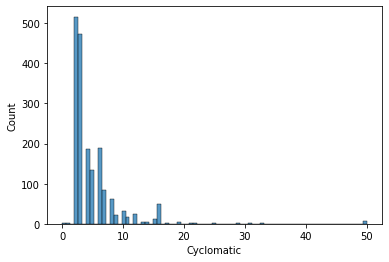

In [57]:
from imblearn.under_sampling import RandomUnderSampler

# usa técnica under-sampling
def under_sampling(d, seed = 0):
    ppc = d.iloc[:,-1].values
    rus = RandomUnderSampler(random_state=seed, sampling_strategy='majority')
    X_res, y_res = rus.fit_resample(d['Name'].values.reshape(-1,1), d['Cyclomatic'].values)
    d['Selected'] = d['Name'].apply(lambda name: name in X_res)
    dataset_filtered = d[d['Selected']]
    dataset_filtered = dataset_filtered.drop('Selected', axis=1)
    d = d.drop('Selected', axis=1)
    
    return dataset_filtered

dataset_filtered = under_sampling(dataset, 0)
print('Dataset size: ', dataset_filtered.shape[0])
print('Média complexidade dataset: ', dataset['Cyclomatic'].mean())
print('Média complexidade dataset balanceado: ', dataset_filtered['Cyclomatic'].mean())
sns.histplot(dataset_filtered['Cyclomatic'])

In [ ]:
ppc = d['PrimePathCoverage'].values
previsores_content = d[previsores].values
resultados = cross_validate(
        classificador, 
        previsores_content, 
        ppc, 
        cv=k, 
        scoring=metricas_erro, 
        return_estimator=True,

)

## Experimentos

In [101]:
#evaluate_metrics(MLPRegressor(), dataset_filtered)

In [35]:
evaluate([
    'CountInput','CountLine','CountLineBlank','CountLineCode','CountLineCodeDecl','CountLineCodeExe',
    'CountLineComment','CountOutput','CountStmt','CountStmtDecl',
    'CountStmtExe','Cyclomatic','CyclomaticModified','CyclomaticStrict','Essential','Knots','MaxEssentialKnots',
    'MaxNesting','MinEssentialKnots',
    
    'CountInput.1','CountLine.1','CountLineBlank.1','CountLineCode.1','CountLineCodeDecl.1','CountLineCodeExe.1',
    'CountLineComment.1','CountOutput.1','CountPath.1','CountPathLog.1','CountStmt.1',
    'CountStmtDecl.1','CountStmtExe.1'
], MLPRegressor(activation='tanh'), dataset_filtered)

C:\ProgramData\Miniconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\ProgramData\Miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Miniconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\ProgramData\Miniconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 87, in __call__
    score = scorer._score(cached_call, estimator,
  File "C:\ProgramData\Miniconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 242, in _score
    return self._sign * self._score_func(y_true, y_pred,
  File "C:\ProgramData\Minic

[0.8    0.7143 0.7    ... 0.4444 0.4444 0.4444]
[[ 2 13  0 ...  2  1  1]
 [ 3 14  0 ...  2  1  1]
 [ 4 15  0 ...  2  1  1]
 ...
 [38 52  1 ... 21  2 19]
 [38 52  1 ... 21  2 19]
 [38 52  1 ... 16  5 11]]
-----< SEM ESCALONAMENTO >-----


NameError: name 'resultados' is not defined

In [50]:
evaluate([
    'Cyclomatic', 
    'CyclomaticModified',
    'CountOutput',
    'Essential',
    'CountLine',
    'EdgeCoverage'
], MLPRegressor(activation='tanh'), dataset_filtered)

C:\ProgramData\Miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Miniconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\ProgramData\Miniconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 87, in __call__
    score = scorer._score(cached_call, estimator,
  File "C:\ProgramData\Miniconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 242, in _score
    return self._sign * self._score_func(y_true, y_pred,
  File "C:\ProgramData\Miniconda3\lib\site-packages\sklearn\utils\validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "C:\ProgramData\Miniconda3\lib\site-packages\sklearn\metrics\_regression.py", line 413, in mean_squared_log_error
    raise ValueError("Mean Squared 

[1.     0.5    0.3333 ... 1.     0.5    0.8571]


TypeError: '<' not supported between instances of 'dict' and 'int'

In [6]:
evaluate([
    'Cyclomatic', 
    'CyclomaticModified',
    'CountOutput',
    'Essential',
    'CountLine',
    'EdgeCoverage'
], MLPRegressor(
        hidden_layer_sizes=(122,), 
        activation='tanh', 
        learning_rate='invscaling', 
        alpha=0.1,
        random_state=0
), dataset_filtered)

C:\ProgramData\Miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Miniconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\ProgramData\Miniconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 87, in __call__
    score = scorer._score(cached_call, estimator,
  File "C:\ProgramData\Miniconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 242, in _score
    return self._sign * self._score_func(y_true, y_pred,
  File "C:\ProgramData\Miniconda3\lib\site-packages\sklearn\utils\validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "C:\ProgramData\Miniconda3\lib\site-packages\sklearn\metrics\_regression.py", line 413, in mean_squared_log_error
    raise ValueError("Mean Squared 

C:\ProgramData\Miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Miniconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\ProgramData\Miniconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 87, in __call__
    score = scorer._score(cached_call, estimator,
  File "C:\ProgramData\Miniconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 242, in _score
    return self._sign * self._score_func(y_true, y_pred,
  File "C:\ProgramData\Miniconda3\lib\site-packages\sklearn\utils\validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "C:\ProgramData\Miniconda3\lib\site-packages\sklearn\metrics\_regression.py", line 413, in mean_squared_log_error
    raise ValueError("Mean Squared 

C:\ProgramData\Miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Miniconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\ProgramData\Miniconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 87, in __call__
    score = scorer._score(cached_call, estimator,
  File "C:\ProgramData\Miniconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 242, in _score
    return self._sign * self._score_func(y_true, y_pred,
  File "C:\ProgramData\Miniconda3\lib\site-packages\sklearn\utils\validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "C:\ProgramData\Miniconda3\lib\site-packages\sklearn\metrics\_regression.py", line 413, in mean_squared_log_error
    raise ValueError("Mean Squared 

-----< SEM ESCALONAMENTO >-----
Mean Abs Error:  nan
Mean Sqr Error:  nan
Mean Sqr Log Error:  nan
Mean Median Error:  nan
R2 Score:  nan
-----< COM ESCALONAMENTO >-----
Mean Abs Error:  nan
Mean Sqr Error:  nan
Mean Sqr Log Error:  nan
Mean Median Error:  nan
R2 Score:  nan


C:\ProgramData\Miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Miniconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\ProgramData\Miniconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 87, in __call__
    score = scorer._score(cached_call, estimator,
  File "C:\ProgramData\Miniconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 242, in _score
    return self._sign * self._score_func(y_true, y_pred,
  File "C:\ProgramData\Miniconda3\lib\site-packages\sklearn\utils\validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "C:\ProgramData\Miniconda3\lib\site-packages\sklearn\metrics\_regression.py", line 413, in mean_squared_log_error
    raise ValueError("Mean Squared 

In [105]:
evaluate([
    'CountInput','CountLine','CountOutput','CountPath','CountStmt','CountStmtDecl','Knots',
    'MaxNesting','MinEssentialKnots',
    
    'CountInput.1','CountLine.1','CountLineCodeDecl.1','CountOutput.1','CountStmtDecl.1','CountStmtExe.1'
], MLPRegressor(activation='tanh'), dataset_filtered)

C:\ProgramData\Miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Miniconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\ProgramData\Miniconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 87, in __call__
    score = scorer._score(cached_call, estimator,
  File "C:\ProgramData\Miniconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 242, in _score
    return self._sign * self._score_func(y_true, y_pred,
  File "C:\ProgramData\Miniconda3\lib\site-packages\sklearn\utils\validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "C:\ProgramData\Miniconda3\lib\site-packages\sklearn\metrics\_regression.py", line 413, in mean_squared_log_error
    raise ValueError("Mean Squared 

C:\ProgramData\Miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Miniconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\ProgramData\Miniconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 87, in __call__
    score = scorer._score(cached_call, estimator,
  File "C:\ProgramData\Miniconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 242, in _score
    return self._sign * self._score_func(y_true, y_pred,
  File "C:\ProgramData\Miniconda3\lib\site-packages\sklearn\utils\validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "C:\ProgramData\Miniconda3\lib\site-packages\sklearn\metrics\_regression.py", line 413, in mean_squared_log_error
    raise ValueError("Mean Squared 

-----< SEM ESCALONAMENTO >-----
Mean Abs Error:  nan
Mean Sqr Error:  nan
Mean Sqr Log Error:  nan
Mean Median Error:  nan
R2 Score:  nan
-----< COM ESCALONAMENTO >-----
Mean Abs Error:  nan
Mean Sqr Error:  nan
Mean Sqr Log Error:  nan
Mean Median Error:  nan
R2 Score:  nan


C:\ProgramData\Miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Miniconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\ProgramData\Miniconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 87, in __call__
    score = scorer._score(cached_call, estimator,
  File "C:\ProgramData\Miniconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 242, in _score
    return self._sign * self._score_func(y_true, y_pred,
  File "C:\ProgramData\Miniconda3\lib\site-packages\sklearn\utils\validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "C:\ProgramData\Miniconda3\lib\site-packages\sklearn\metrics\_regression.py", line 413, in mean_squared_log_error
    raise ValueError("Mean Squared 

In [106]:
evaluate([
    'MaxNesting', 
    'CountPath', 
    'CountStmtExe', 
    'CountInput', 
    'CountOutput',
    'CountStmtExe.1'
], MLPRegressor(activation='tanh'), dataset_filtered)

C:\ProgramData\Miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Miniconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\ProgramData\Miniconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 87, in __call__
    score = scorer._score(cached_call, estimator,
  File "C:\ProgramData\Miniconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 242, in _score
    return self._sign * self._score_func(y_true, y_pred,
  File "C:\ProgramData\Miniconda3\lib\site-packages\sklearn\utils\validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "C:\ProgramData\Miniconda3\lib\site-packages\sklearn\metrics\_regression.py", line 413, in mean_squared_log_error
    raise ValueError("Mean Squared 

C:\ProgramData\Miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Miniconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\ProgramData\Miniconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 87, in __call__
    score = scorer._score(cached_call, estimator,
  File "C:\ProgramData\Miniconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 242, in _score
    return self._sign * self._score_func(y_true, y_pred,
  File "C:\ProgramData\Miniconda3\lib\site-packages\sklearn\utils\validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "C:\ProgramData\Miniconda3\lib\site-packages\sklearn\metrics\_regression.py", line 413, in mean_squared_log_error
    raise ValueError("Mean Squared 

-----< SEM ESCALONAMENTO >-----
Mean Abs Error:  nan
Mean Sqr Error:  nan
Mean Sqr Log Error:  nan
Mean Median Error:  nan
R2 Score:  nan
-----< COM ESCALONAMENTO >-----
Mean Abs Error:  nan
Mean Sqr Error:  nan
Mean Sqr Log Error:  nan
Mean Median Error:  nan
R2 Score:  nan


In [107]:
evaluate([
    'Cyclomatic', 
    'CyclomaticModified', 
    'CyclomaticStrict', 
    'CountInput', 
    'CountOutput',
    'EdgeCoverage',
    'CountStmtExe.1'
], MLPRegressor(activation='tanh'), dataset_filtered)

C:\ProgramData\Miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Miniconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\ProgramData\Miniconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 87, in __call__
    score = scorer._score(cached_call, estimator,
  File "C:\ProgramData\Miniconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 242, in _score
    return self._sign * self._score_func(y_true, y_pred,
  File "C:\ProgramData\Miniconda3\lib\site-packages\sklearn\utils\validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "C:\ProgramData\Miniconda3\lib\site-packages\sklearn\metrics\_regression.py", line 413, in mean_squared_log_error
    raise ValueError("Mean Squared 

C:\ProgramData\Miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Miniconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\ProgramData\Miniconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 87, in __call__
    score = scorer._score(cached_call, estimator,
  File "C:\ProgramData\Miniconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 242, in _score
    return self._sign * self._score_func(y_true, y_pred,
  File "C:\ProgramData\Miniconda3\lib\site-packages\sklearn\utils\validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "C:\ProgramData\Miniconda3\lib\site-packages\sklearn\metrics\_regression.py", line 413, in mean_squared_log_error
    raise ValueError("Mean Squared 

C:\ProgramData\Miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Miniconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\ProgramData\Miniconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 87, in __call__
    score = scorer._score(cached_call, estimator,
  File "C:\ProgramData\Miniconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 242, in _score
    return self._sign * self._score_func(y_true, y_pred,
  File "C:\ProgramData\Miniconda3\lib\site-packages\sklearn\utils\validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "C:\ProgramData\Miniconda3\lib\site-packages\sklearn\metrics\_regression.py", line 413, in mean_squared_log_error
    raise ValueError("Mean Squared 

-----< SEM ESCALONAMENTO >-----
Mean Abs Error:  nan
Mean Sqr Error:  nan
Mean Sqr Log Error:  nan
Mean Median Error:  nan
R2 Score:  nan
-----< COM ESCALONAMENTO >-----
Mean Abs Error:  nan
Mean Sqr Error:  nan
Mean Sqr Log Error:  nan
Mean Median Error:  nan
R2 Score:  nan


C:\ProgramData\Miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Miniconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\ProgramData\Miniconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 87, in __call__
    score = scorer._score(cached_call, estimator,
  File "C:\ProgramData\Miniconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 242, in _score
    return self._sign * self._score_func(y_true, y_pred,
  File "C:\ProgramData\Miniconda3\lib\site-packages\sklearn\utils\validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "C:\ProgramData\Miniconda3\lib\site-packages\sklearn\metrics\_regression.py", line 413, in mean_squared_log_error
    raise ValueError("Mean Squared 